# Objective

This notebook shows the spot images and parameters generated for Figure 2b and ready for worker annotations.
 -	background image: MAX_ISP_300_2.tif (tissue)
 -  spot density = [0.0025, 0.0027, 0.003, 0.0037, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
 -	SNR mu, sigma = 7, 1
 -	number of spots: desired = 100

In [1]:
import sys
sys.path.insert(0, '../../../../FISH-annotation/SpotImage')
from SpotImage import SpotImage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KDTree
from matplotlib.lines import Line2D
import math

"""
Instantiate the SpotImage.
"""

bg_img_path = 'MAX_ISP_300_2.tif'
global_intensity_dial = 0.9   # raise the threshold found by Otsu's

### These parameters are the same for all images in this batch.

In [2]:
snr_sigma = 1
snr_mu = 7
snr_threshold = 3

### This parameter varies.

In [3]:
density_list = [0.0025, 0.0027, 0.003, 0.0037, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]

### Generate spot images.

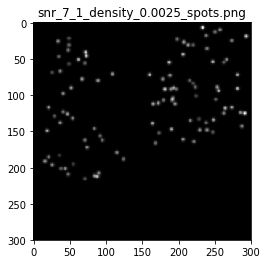

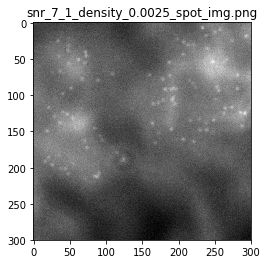

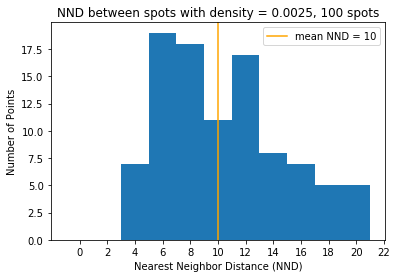

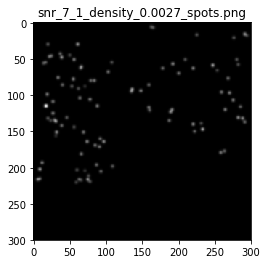

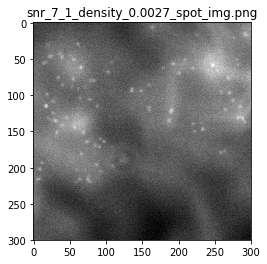

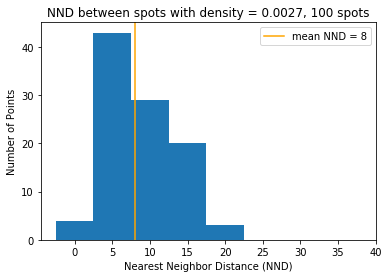

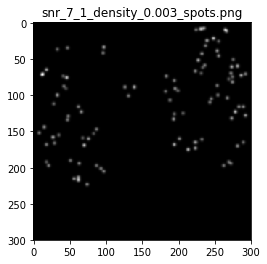

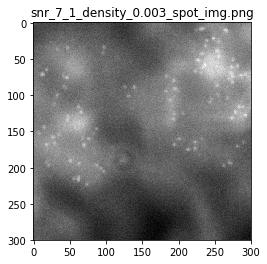

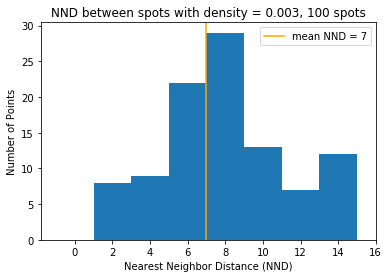

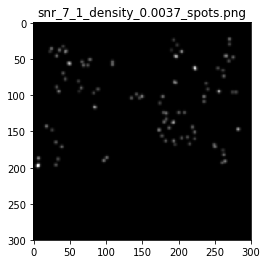

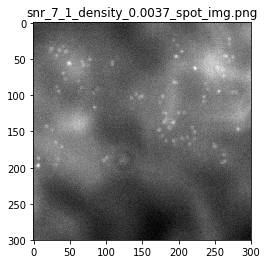

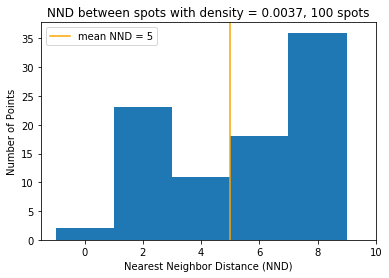

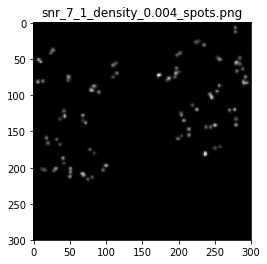

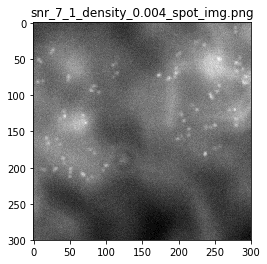

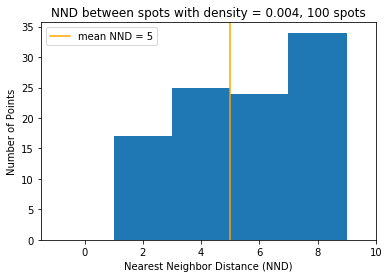

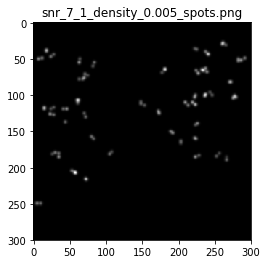

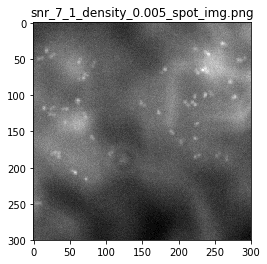

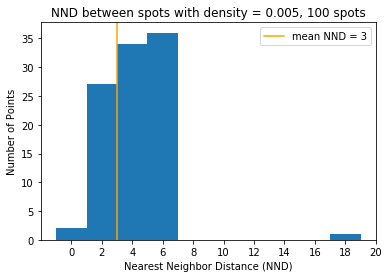

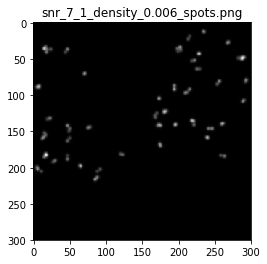

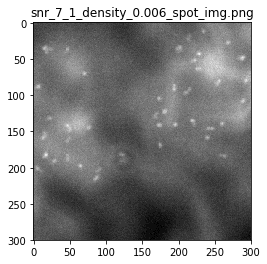

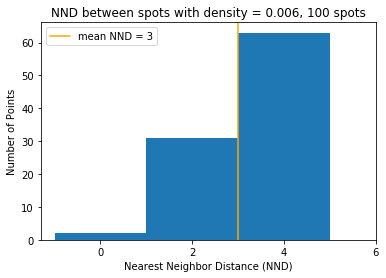

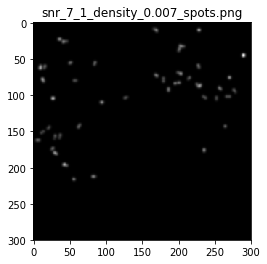

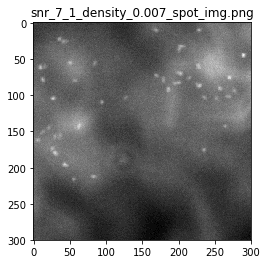

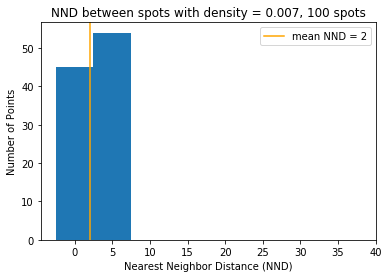

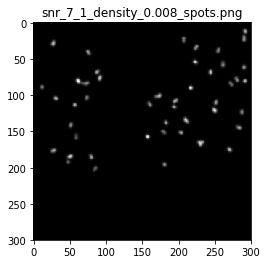

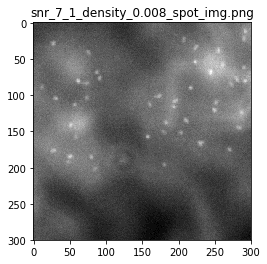

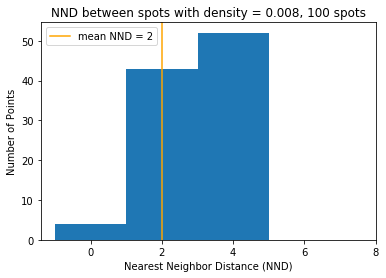

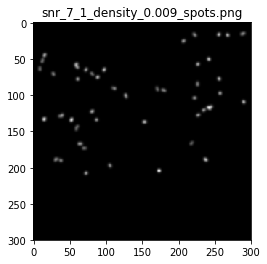

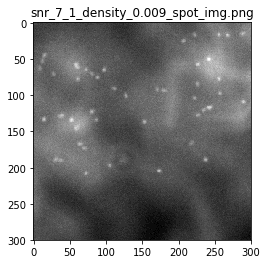

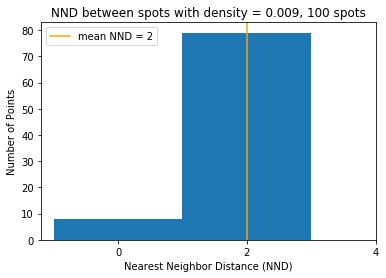

In [4]:
densities = []
mean_NNDs = []
snr_distr_params = ['Gauss', snr_mu, snr_sigma]

NND_list_list = []
for density in density_list:
    si = SpotImage(bg_img_path = bg_img_path, global_intensity_dial = global_intensity_dial)
    name = 'snr_' + str(snr_mu) + '_' + str(snr_sigma) + '_density_' + str(density)
    spots_filename = name + '_spots.png'
    spot_img_filename = name + '_spot_img.png'
    csv_filename = name + '_coord_snr_list.csv'

    si.generate_spot_image(snr_distr_params = snr_distr_params, snr_threshold = snr_threshold, spots_filename = spots_filename, spot_img_filename = spot_img_filename, density = density)

    # get list of all coordinates in si right now.
    coords = [si.coord_list[i] for i in range(si.num_spots)]
    coords_kdt = KDTree(coords, leaf_size=2, metric='euclidean')

    # get their NNDs
    NND_list = []
    for coord in coords:
        coord = [coord]
        dist, ind = coords_kdt.query(coord, k=2)
        NND_list.append(dist[0][1])

    # get the 100 coords with smallest NNDs

    num_to_remove = si.num_spots - 100

    # Source: https://stackoverflow.com/questions/16878715/how-to-find-the-index-of-n-largest-elements-in-a-list-or-np-array-python?lq=1
    ordered_indices = sorted(range(len(NND_list)), key=lambda x: NND_list[x])
    indices_to_remove = sorted(range(len(NND_list)), key=lambda x: NND_list[x])[-num_to_remove:]

    coords_100 = []
    for i in range(len(coords)):
        if i not in indices_to_remove:
            coords_100.append(coords[i])

    # generate spot list
    spot_list = [[coords_100[i], si.get_patch(si.coord_list[i], si.snr_list[i])] for i in range(100)]

    # generate spot array
    spot_array = np.zeros([si.img_sz, si.img_sz])
    for i in range(100):
        si.add_spot(spot_list[i], spot_array)

    # add bg and spot array
    spot_img = np.add(si.bg_array, spot_array)

    # plot and save spot images

    plt.imshow(spot_array, cmap = 'gray')
    plt.title(spots_filename)
    plt.show()
    plt.imsave(spots_filename, si.spot_array, cmap = 'gray')

    plt.imshow(spot_img, cmap = 'gray')
    plt.title(spot_img_filename)
    plt.show()
    plt.imsave(spot_img_filename, spot_img, cmap = 'gray')

    # save csv
    coord_snr_list = [None]*100
    for i in range(100):
        spot = [coords_100[i][0], coords_100[i][1], si.snr_list[i]]
        coord_snr_list[i] = spot
    np.savetxt(csv_filename, coord_snr_list, delimiter=",", comments='', header = "col,row,snr")

    # find mean NND

    spots_kdt = KDTree(coords_100, leaf_size=2, metric='euclidean')

    NND_list = []
    for coord in coords_100:
        coord = [coord]
        dist, ind = spots_kdt.query(coord, k=2)
        NND_list.append(dist[0][1])

    NND_list_list.append(NND_list)
    mean_NND = np.mean(NND_list)

    # plot NNDs

    step_size = 2
    if(max(NND_list) > 30):
        step_size = 5

    plt.hist(NND_list, bins = np.arange(0,max(NND_list)+step_size,step=step_size)-step_size/2)
    plt.title("NND between spots with density = " + str(density) + ", " + str(100) + " spots")
    plt.xlabel("Nearest Neighbor Distance (NND)")
    plt.ylabel("Number of Points")
    plt.xticks(np.arange(0,max(NND_list)+step_size,step=step_size))

    mean = math.floor(np.mean(NND_list))

    plt.axvline(x=mean, color='orange')
    label = "mean NND = " + str(mean)
    mean_line = Line2D([0],[0], color='orange', label=label)
    plt.legend(handles=[mean_line])

    plt.show()

    densities.append(density)
    mean_NNDs.append(mean_NND)

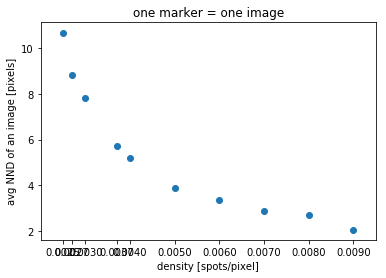

In [5]:
plt.scatter([densities], [mean_NNDs])
plt.xlabel('density [spots/pixel]')
plt.ylabel('avg NND of an image [pixels]')
plt.xlim(min(density_list)-0.0005, max(density_list)+0.0005)
plt.xticks(density_list)
plt.title('one marker = one image')
plt.show()

# Supplemental Figure: NND Histogram

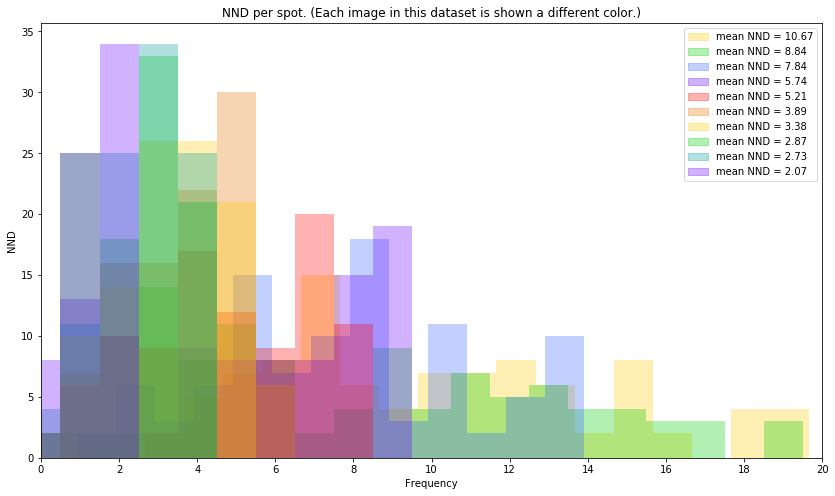

In [6]:
import matplotlib.patches as mpatches
a = 0.3
colors = [(255/255, 204/255, 0/255, a), (0, 204/255, 0/255, a), (51/255, 102/255, 255/255, a), (102/255, 0, 255/255, a), (255/255, 0, 0, a), (230/255, 115/255, 0/255, a), (255/255, 204/255, 0/255, a), (0, 204/255, 0/255, a), (0, 153/255, 153/255, a), (102/255, 0, 255/255, a)]

fig = plt.figure(figsize=(14,8))
handles = []
for NND_list, color in zip(NND_list_list, colors):
    plt.hist(NND_list, fc=color, bins = np.arange(min(NND_list), max(NND_list)+0.5, 1)-0.5)
    handles.append(mpatches.Patch(color=color, label='mean NND = ' + str(round(np.mean(NND_list), 2))))
plt.legend(handles = handles)
plt.xlabel('Frequency')
plt.ylabel('NND')
plt.xlim(0, 20)
plt.xticks(np.arange(0, 21, 2))
plt.title('NND per spot. (Each image in this dataset is shown a different color.)')
plt.show()

It's hard to tell what's going on in the combined plot, so here they are separately:

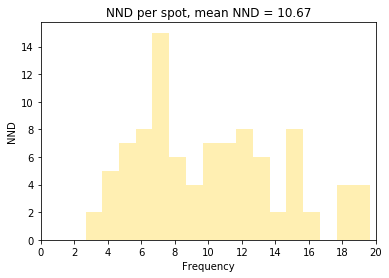

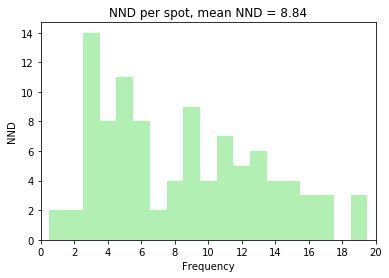

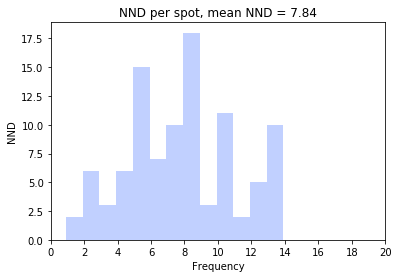

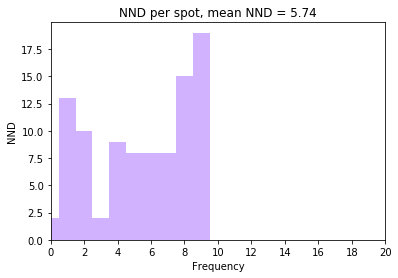

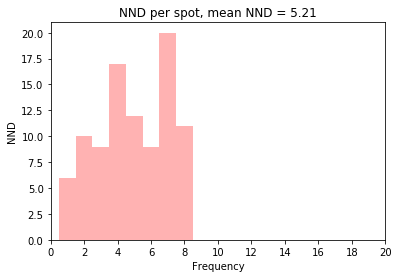

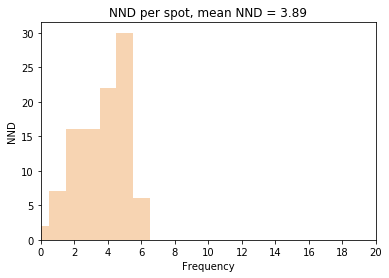

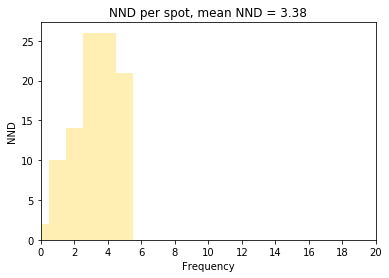

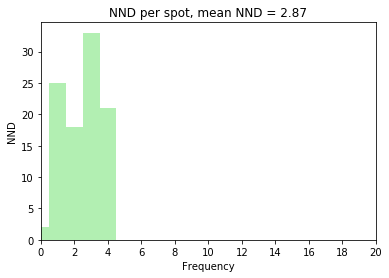

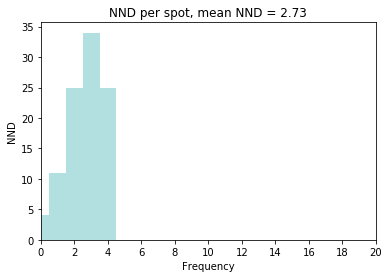

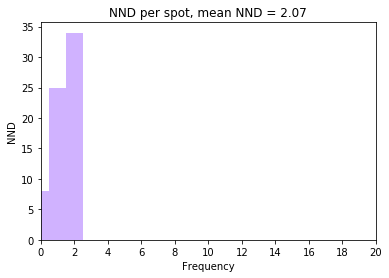

In [7]:
a = 0.7

means = []
for NND_list, color in zip(NND_list_list, colors):
    fig = plt.figure()
    plt.hist(NND_list, fc=color, bins = np.arange(min(NND_list), max(NND_list)+0.5, 1)-0.5)
    means.append(np.mean(NND_list))
    handles.append(mpatches.Patch(color=color))
    plt.xlabel('Frequency')
    plt.ylabel('NND')
    plt.xlim(0, 20)
    plt.xticks(np.arange(0, 21, 2))
    plt.title('NND per spot, mean NND = ' + str(round(np.mean(NND_list), 2)))
    plt.show()

## Demonstrating that we have a variety of average NNDs

Text(0.5,1,'one marker = one image')

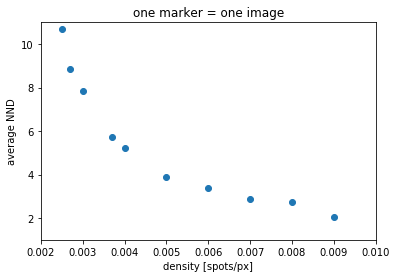

In [8]:
plt.scatter(density_list, means)
plt.xlim(0.002, 0.010)
plt.ylim(1, 11)
plt.xlabel('density [spots/px]')
plt.ylabel('average NND')
plt.title('one marker = one image')